<a href="https://colab.research.google.com/github/entruv/code_stream/blob/master/chess/03_11_2020_Utiliser_Recherche_d'arbre_echecs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recapitulatif de l'avancement pour l'IA des echecs

Lien du precedent notebook:
https://github.com/entruv/code_stream/blob/master/chess/03-10-2020%20Small%20Model%20learn%20legal%20moves%20chess.ipynb

- [x] Avoir un modele qui peut predire des probabilites pour chaque coup, et estimer qui a l'avantage dans une position d'echecs
- [ ] simuler une partie d'echecs, cela va creer un Arbre ou les noeuds sont des positions d'echecs
- [ ] sauvegarder les resultats de cette simulation et entrainer le modele a predire qui avait l'avantage, sans faire de simulation

In [0]:
import chess
import numpy as np



## Helper fonctions: Generer la liste des coups aux echecs

['a1b1', 'a1c1', 'a1d1', 'a1e1', 'a1f1', 'a1g1', 'a1h1', 'a1a2', 'a1a3', 'a1a4', 'a1a5', 'a1a6', 'a1a7', 'a1a8', 'a1b2', 'a1c3', 'a1d4', 'a1e5', 'a1f6', 'a1g7', 'a1h8', 'a1c2', 'a1b3', 'a2b2', 'a2c2', 'a2d2', 'a2e2', 'a2f2', 'a2g2', 'a2h2', 'a2a1', 'a2a3', 'a2a4', 'a2a5', 'a2a6', 'a2a7', 'a2a8', 'a2b3', 'a2c4', 'a2d5', 'a2e6', 'a2f7', 'a2g8', 'a2b1', 'a2c1', 'a2c3', 'a2b4', 'a3b3', 'a3c3', 'a3d3', 'a3e3', 'a3f3', 'a3g3', 'a3h3', 'a3a1', 'a3a2', 'a3a4', 'a3a5', 'a3a6', 'a3a7', 'a3a8', 'a3b4', 'a3c5', 'a3d6', 'a3e7', 'a3f8', 'a3b2', 'a3c1', 'a3b1', 'a3c2', 'a3c4', 'a3b5', 'a4b4', 'a4c4', 'a4d4', 'a4e4', 'a4f4', 'a4g4', 'a4h4', 'a4a1', 'a4a2', 'a4a3', 'a4a5', 'a4a6', 'a4a7', 'a4a8', 'a4b5', 'a4c6', 'a4d7', 'a4e8', 'a4b3', 'a4c2', 'a4d1', 'a4b2', 'a4c3', 'a4c5', 'a4b6', 'a5b5', 'a5c5', 'a5d5', 'a5e5', 'a5f5', 'a5g5', 'a5h5', 'a5a1', 'a5a2', 'a5a3', 'a5a4', 'a5a6', 'a5a7', 'a5a8', 'a5b6', 'a5c7', 'a5d8', 'a5b4', 'a5c3', 'a5d2', 'a5e1', 'a5b3', 'a5c4', 'a5c6', 'a5b7', 'a6b6', 'a6c6', 'a6d6',

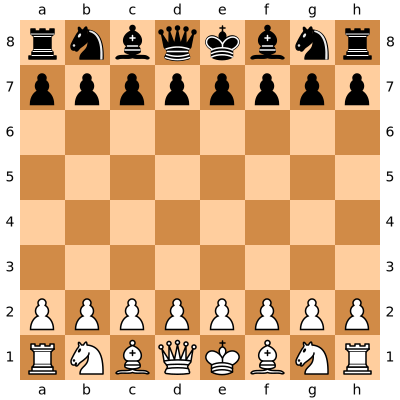

In [23]:
def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #indice colonnes echiquier
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8'] #indice lignes echiquier
    promoted_to = ['q', 'r', 'b', 'n'] #list of the available promotion for the pawn

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array
all_moves = create_uci_labels()
print(all_moves)
board = chess.Board()
print(list(board.legal_moves))
print(board.fen())
board

## Node definition: Chess Board

In [0]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import copy #permet de copier un objet proprement

class BoardAi(chess.Board): #Node
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    # def copy(self):
    #   return copy.copy(self)

    def get_numpy_board(self):
      def transform_line(line):
          result = ""
          for character in line:
              if character.isdigit():
                  for i in range(int(character)):
                      result += "1"
              else:
                  result += character
          return result
      
      def compute_en_passant(ep_square):
          def alg_to_coord(alg):
              rank = 8 - int(alg[1])        # 0-7
              file = ord(alg[0]) - ord('a') # 0-7 #WTF ord("a")??
              return rank, file
          # renvoie une matrice de la taille dun jeu d'echec, contenant True si la case possede un 
          #pion que l'on peut manger en passant
          en_passant = np.zeros((8, 8, 1), dtype=np.bool)
          if ep_square != '-':
              eps = alg_to_coord(ep_square)
              en_passant[eps[0]][eps[1]] = True
          return en_passant

      fen_data = self.fen().split(" ")
      fen, turn, castling, ep_square, half_move_clock, fullmove_number = fen_data
      en_passant = compute_en_passant(ep_square)
      auxiliary_planes = [np.full((8, 8, 1), ('K' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('Q' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('k' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('q' in castling), dtype=np.bool),
                          en_passant]
      
      piece_information_plane = np.zeros((8,8, len(one_hot_dictionary)))
      for i, line in enumerate(fen.split("/")):
          for j, case in enumerate(transform_line(line)):
              piece_information_plane[i][j] = one_hot_dictionary[case]    
      all_planes = auxiliary_planes + [piece_information_plane]
      all_planes_numpy = np.concatenate(all_planes, axis=-1).astype(np.float32)
      return all_planes_numpy

    def find_legal_moves(self):
      return list(self.legal_moves)
    
    def get_children(self, move_str):
      board = self.copy()
      board.push(move)
      return board
  
    def find_children(self):
      "All possible successors of this board state"
      childrens = []
      for move in self.find_legal_moves():
          board = self.copy()
          board.push(move)
          childrens.append(board)
      return childrens

    def find_random_child(self):
      childrens = self.find_children()
      if childrens:
        return np.random.choice(childrens)
        "Random successor of this board state (for more efficient simulation)"
      return None

    def is_terminal(self):
      # use the 50 move rule to stop the game accordingly
      return len(self.find_children()) == 0 or self.can_claim_draw()


    def get_reward(self, result):
      if result == "1-0":
          return 1
      if result == "0-1":
          return -1
      if result == "1/2-1/2":
          return 0 #biais pour explorer les parties qui ne rendent pas un etat null
      return 0
    def reward(self):
      "Assumes `self` is terminal node."
      result = self.result() #vient de la classe parent chess.Board()
      print(f"Resultat de la partie: {result}")
      return self.get_reward(result)

    def identifier(self):
      return str(self.board_fen()) + str(self.turn) + str(self.castling_rights) + str(self.ep_square)
    
    def __hash__(self):
        "Nodes must be hashable"
        #permet de distinguer si deux noeuds sont identiques ou differents. Utile car mes noeuds sont des objets pythons difficile a comparer par nature
        return hash(self.identifier())
    
    def __eq__(node1, node2):
      return node1.identifier() == node2.identifier()

## MCTS algorithm 

In [0]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = True
        while True:
            if node.is_terminal():
              reward = node.reward()
              return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa


    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


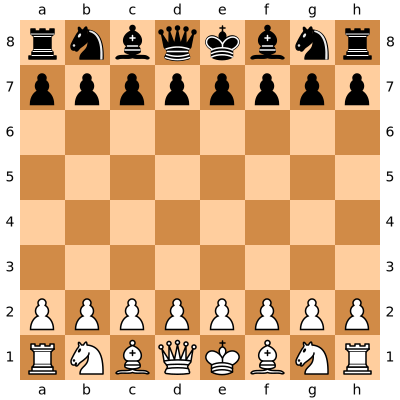

In [0]:
import chess
tree = MCTS()
board = BoardAi()
board

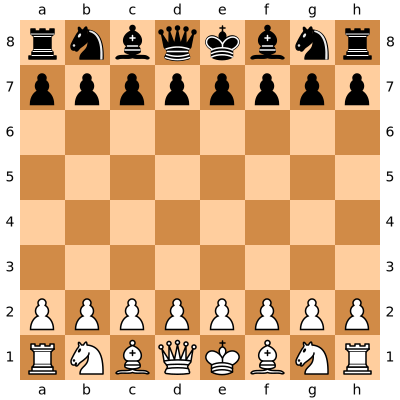

In [0]:
board

In [0]:
tree.do_rollout(board) #4secondes to simulate an entire game!!

Resultat de la partie: 1-0


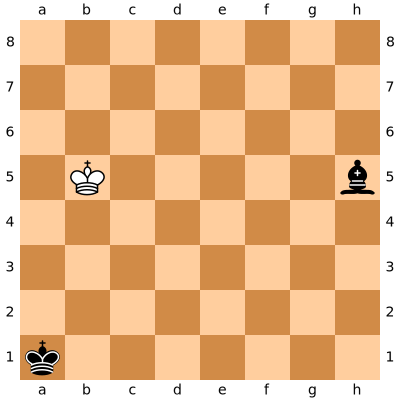

In [0]:
#visualisons le dernier coup:
BoardAi("8/8/8/1K5b/8/8/8/k7 b - - 99 215")

## Visualisation de Q et de N, et des poids d'exploration

In [0]:
tree.Q #represente score pour chaque position du jeu

defaultdict(int,
            {BoardAi('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'): 1})

In [0]:
tree.N #represente le nombre de visites pour chaque position

defaultdict(int,
            {BoardAi('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'): 1})

In [0]:
tree.exploration_weight

1

##Suite: MCTS with AI algorithm (MCTSAI)


Definissons un nouvel arbre qui va entrainer notre IA a chaque fin de partie (ou bien une fois que le nombre de position depasse un certain seuil)*italicized text*

### Helpers methods

Il faut convertir (serializer) la facon d'ecrire les positions du modele de machine learniner vers la facon d'ecrire les positions par la convention utilise par la librairie python-chess. C'est ce fait le code ci-dessous:

In [0]:

all_moves_dict_str = {move: i for i, move in enumerate(all_moves)}
all_moves_dict_index = {i: move for i, move in enumerate(all_moves)}
## passer d'indices a coup et de coup a indices
def get_move_index(move_str):
  #renvoie l'index d'un coup sous forme de charactere
  return all_moves_dict_str[move_str]

def get_move_str(move_index):
  # renvoie le coup en charactere a partir de l'indice du coup
  return all_moves_dict_index[move_index]

# def get_mode_node(move_index):
#   move_str = 

def proba_to_policy(node, probabilities):
  # projecte la probabilite des coups du modele vers la sous liste des coup possibles,
  # en renormalisant le tout
  probabilities = np.zeros(len(all_moves))
  legal_moves = node.legal_moves()
  policy = {}
  for move in legal_moves:
    policy[move] = probabilities[get_move_index(str(move))]
assert get_move_str(32) == get_move_str(get_move_index('a2a4')) #big test

In [0]:
class MCTSAI(≈):
  def __init__(self, model_white, model_black,  exploration_weight=1):
    #j'initialise avec un model en supplement de ma classe de depart
    super().__init__(exploration_weight)
    self.model_white = model_white
    self.model_black = model_black
    self.Q_model = defaultdict(int)
    self.all_moves_dict = {i: move for i, move in enumerate(create_uci_labels())}

  def _model_select(self, node):
      # selectionne un coup choisis par le modele de Mahcine Learning, et 
      # entraine le modele en fonction de ses "mauvaises" predictions
      
      #the policy the model should predict
      policy = [self.Q[children] / self.N[children] for children in self.children[node]]
      
      for children in childrens:

      if node.turn == chess.WHITE:
        model = self.model_white
      else:
        model = self.model_black
      input_model = node.get_numpy_board() #l'entree de mon modele
      # where can I store the probability prediction of next moves?
      probs, self.Q_model[node] = model.predict(input_model)
      legal_moves = list(node.legal_moves())
      #cette ligne fait pas mal de choses:
      # 1. selectionne seulement les coups legaux
      # 2. associe a chaque coup legaux la probabilite predicte par le model
      # 3. Sauvegarde tout ca dans un dictionnaire key: coup, valeur: probability
      # 4. renormalisation des probabilites
      policy_predicted = {get_move_str(i): x for i, x in enumerate(probs) if get_move_str(i) in legal_moves}
      sum_proabilities = np.sum(list(policy.values())) #should be less than 1 because a subset
      policy_predicted = {k:(v/sum_probabilities+ self.exploration_weight*)  for  k,v in policy.items()}
      #remarque: attention a conserver l'ordre dans le dictionnaire? Ok python > 3.6
      move_sampled = np.random.choice(list(policy.keys()),p=list(policy.values()))

### Importer le modele existant

Le stream datanat du 10 Avril ( https://github.com/entruv/code_stream/blob/master/chess/03-10-2020%20Small%20Model%20learn%20legal%20moves%20chess.ipynb) contient le code pour entrainer un modele. Importons le!!

Nous devons predire le score et la probabilite des coups pour ce modele specifique, il va falloir l'adapter un peu

In [0]:
import tensorflow.keras as keras

# import keras #already present in tensorflow 2.0 whitout bugs
from keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense
from keras.models import Model
def model_moves_and_score():
    NUMBER_FILTERS = 16
    shape_board = (8,8,18)
    number_moves = len(all_moves)
    #take a numpy array representing a board as input, and who plays first, and then return
    # the value of a game, number between -1 and 1
    board = Input(shape=(shape_board))
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu", padding="same")(board)
    features = BatchNormalization()(features)
    features = Conv2D(filters=NUMBER_FILTERS, kernel_size=3,activation="relu", padding="same")(features)
    features = BatchNormalization()(features)
    features = Conv2D(filters=2, kernel_size=3,activation="relu", padding="same")(features)
    print(features.shape)
    features = Flatten()(features)
    value_prediction = Dense(1, activation="tanh")(features) 
    policy_prediction = Dense(number_moves, activation="sigmoid")(features)
    model = Model(board, [policy_prediction, value_prediction])
    # il y a deux fonctions de pertes car 2 outputs: un vecteur de probabilites 
    #pour tout les coups possibles ainsi que le score de la position (qui definit qui a l'avantage, les blancs ou les noirs)
    model.compile(loss=["categorical_crossentropy", "mean_squared_error"], optimizer="Adam")
    model.summary()
    return model
model_black = model_moves_and_score()
model_white = model_moves_and_score()

(None, 8, 8, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 8, 8, 18)     0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 8, 16)     2608        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 8, 8, 16)     64          conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 8, 8, 16)     2320        batch_normalization_7[0][0]      
____________________________________________________________________________

## Pourquoi une IA qui joue pour les blancs et une IA qui joue pour les noir?

Car le jeux d'echecs n'est pas symmetrique. Du coup, il est difficile de representer la position des noirs en tant que position des blancs. On pourrait eventuellement retourner l'echiquier d''une certaine facon, et faire jouer le blanc/noir dans ce cas (a faire pour un prochain exercice)

In [0]:
mcts_ai = MCTSAI(model_white, model_black, exploration_weight=1)

In [0]:
# 
https://github.com/ShailChoksi/lichess-bot

In [12]:
import chess
import numpy as np
board = chess.Board()
number_moves = 500
for i in range(number_moves):
  legal_moves =  v
  if not legal_moves:
    print(f"There is no more moves to do. PArty is over! here is the result: {board.result()}")
    break
  random_move = np.random.choice(legal_moves)
  board.push(random_move)
board

There is no more moves to do. PArty is over! here is the result: 0-1


ValueError: ignored

In [14]:
board = chess.Board()
list(board.legal_moves)

[Move.from_uci('g1h3'),
 Move.from_uci('g1f3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1a3'),
 Move.from_uci('h2h3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f2f3'),
 Move.from_uci('e2e3'),
 Move.from_uci('d2d3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('h2h4'),
 Move.from_uci('g2g4'),
 Move.from_uci('f2f4'),
 Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('c2c4'),
 Move.from_uci('b2b4'),
 Move.from_uci('a2a4')]

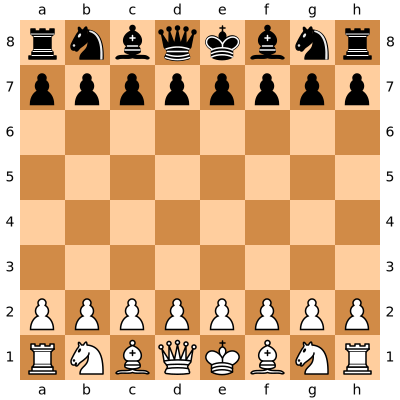

In [15]:
board